# Prediction
This notebook will attempt to build a model to predict the outcome of the passangers

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
%matplotlib inline 

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-titanic/venv/lib64/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data 
Column definitions:  
  
| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survived | Survived                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex	   | Sex	                                    | 0 = Female, 1 = Male                           |
| Age	   | Age in years	                            |                                                |
| sibsp	   | # of siblings / spouses aboard the Titanic |	                                             |
| parch	   | # of parents / children aboard the Titanic	|                                                |
| fare	   | Passenger fare	                            |                                                |
| embarked | Port of Embarkation                        | 0 = Southampton, 1 = Cherbourg, 2 = Queenstown |

In [2]:
train = pd.read_csv("./data/clean/train.csv").head(150)
test = pd.read_csv("./data/clean/test.csv").head(150)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,0,7.9250,0
3,1,1,0,35,1,0,53.1000,0
4,0,3,1,35,0,0,8.0500,0


### Create test datasets
Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models

In [3]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

## Helpers

In [4]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

Create a class to extend the Sklearn classifier

In [5]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
        

### Out-of-Fold Predictions
Stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [6]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generate base level models

### Random forest

In [7]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

In [8]:
# Create helper
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

In [9]:
# Create OOF train and test predictions
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-titanic/venv/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


### Extra trees

In [10]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [11]:
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)

In [12]:
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-titanic/venv/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


### AdaBoost

In [13]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

In [14]:
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

In [15]:
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)

### Graident boosting

In [16]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [17]:
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [18]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)

### Support vector

In [19]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [20]:
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [21]:
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)

## Generate feature Importance for base models

In [22]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-titanic/venv/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [23]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
                                   'Random Forest feature importances': rf_feature,
                                   'Extra Trees  feature importances': et_feature,
                                   'AdaBoost feature importances': ada_feature,
                                   'Gradient Boost feature importances': gb_feature
                                  })

In [24]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.060558,0.075042,0.010,0.020297
1,Sex,0.354900,0.646962,0.062,0.040545
2,Age,0.222084,0.066718,0.298,0.116947
3,SibSp,0.054614,0.061317,0.016,0.022536
4,Parch,0.035237,0.026011,0.040,0.006157
5,Fare,0.216179,0.061412,0.566,0.214583
6,Embarked,0.056429,0.062539,0.008,0.010934


### Visualise feature importance

In [25]:
def plot_feature_importance(x, y, data):
    plt.figure(figsize=(14,8))
    plt.title(y, y=1.05, size=15)
    sns.barplot(x=x, y=y, data=data)

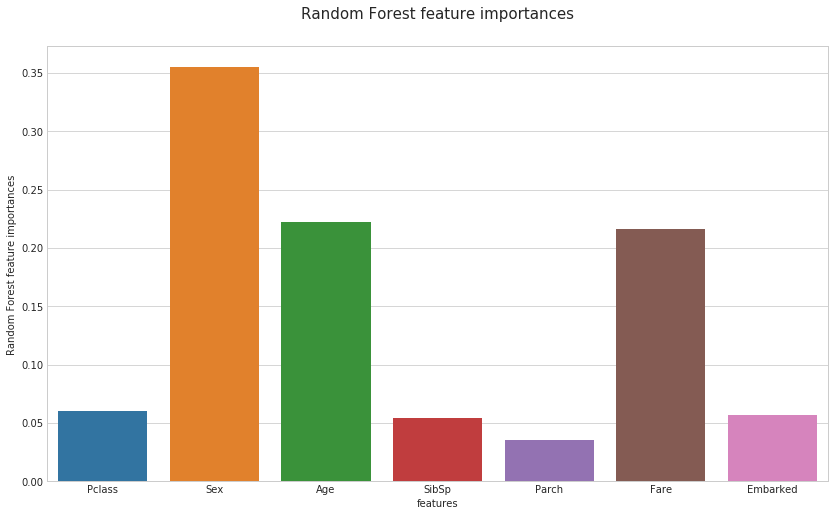

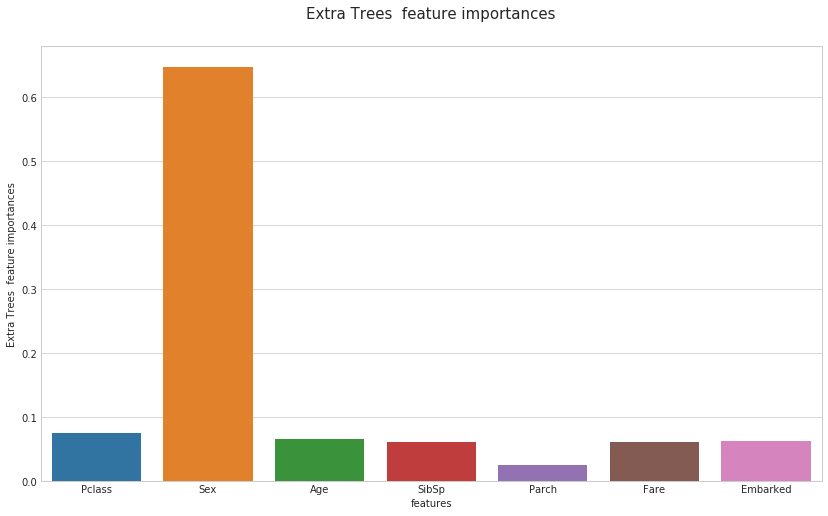

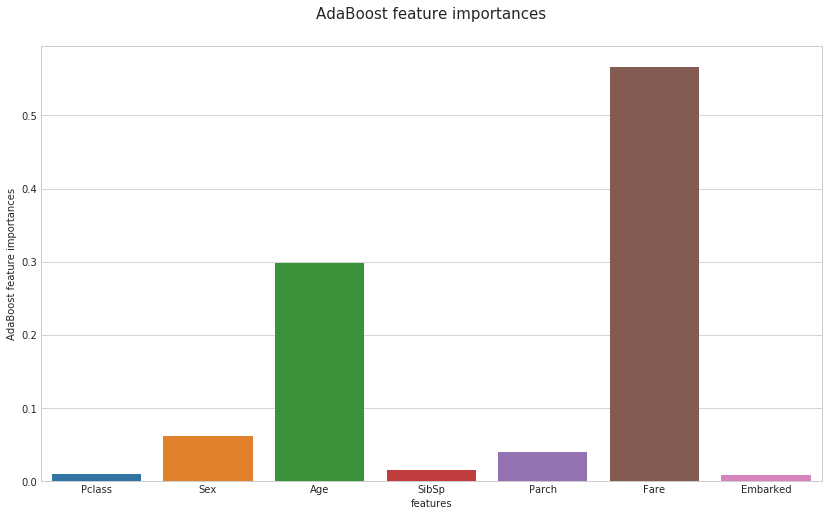

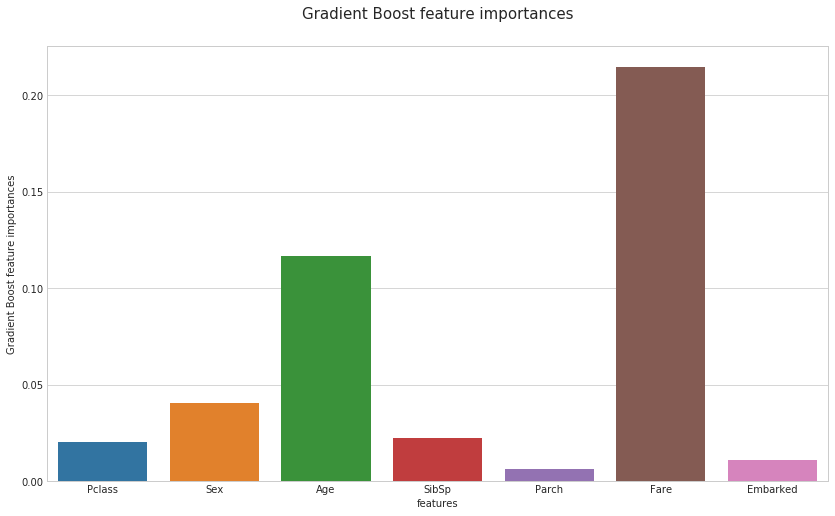

In [26]:
for col in feature_dataframe.columns[1:]:
    plot_feature_importance(x="features", y=col, data=feature_dataframe)

### Calculate the mean of the feature importances

In [27]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.060558,0.075042,0.010,0.020297,0.041474
1,Sex,0.354900,0.646962,0.062,0.040545,0.276101
2,Age,0.222084,0.066718,0.298,0.116947,0.175937
3,SibSp,0.054614,0.061317,0.016,0.022536,0.038617
4,Parch,0.035237,0.026011,0.040,0.006157,0.026851


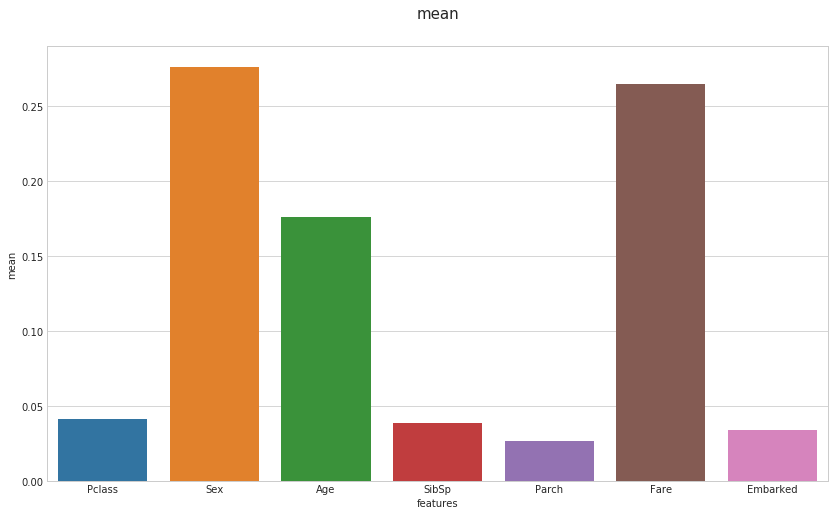

In [28]:
plot_feature_importance(x="features", y="mean", data=feature_dataframe)

## Second level predictions